# Image Captioning Project

## Imports

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model

In [2]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

## Image Feature Extraction 

Import VGG16 and restructure to leave out the last Dense layer. 

In [3]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


### Load Images

In [4]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224,224))
    
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
    image = preprocess_input(image)
    
    feature = model.predict(image, verbose=0)
    
    img_id = img_name.split('.')[0]
    
    features[img_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1731759834.990986      96 service.cc:145] XLA service 0x785040004240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731759834.991042      96 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731759836.923734      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Let's store the features

In [5]:
pickle.dump(features, open(os.path.join(WORKING_DIR,'features.pkl'), 'wb'))

In [6]:
with open(os.path.join(WORKING_DIR,'features.pkl'), 'rb') as f:
    features = pickle.load(f)

### Load Captions

In [7]:
with open(os.path.join(BASE_DIR,'captions.txt'), 'r') as f:
    next(f) #skip first line
    captions = f.read()

### Map images to captions

In [8]:
mapping = {}
for line in tqdm(captions.split('\n')):
    tokens = line.split(',')
    if len(line)<2:
        continue
    img_id, caption = tokens[0], tokens[1:]
    img_id = img_id.split('.')[0]
    
    caption = " ".join(caption) #convert list to single string
    if img_id not in mapping:
        mapping[img_id] = []
    mapping[img_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

## Pre-Process Text Data

In [9]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            
            caption = " ".join([word for word in caption.split() if len(word)>1])
            
            caption = 'tagstart ' + caption + ' endtag'
            captions[i] = caption
            
clean(mapping)


### Tokenize

In [10]:
all_captions = []

for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [11]:
all_captions[:10]

['tagstart child in pink dress is climbing up set of stairs in an entry way endtag',
 'tagstart girl going into wooden building endtag',
 'tagstart little girl climbing into wooden playhouse endtag',
 'tagstart little girl climbing the stairs to her playhouse endtag',
 'tagstart little girl in pink dress going into wooden cabin endtag',
 'tagstart black dog and spotted dog are fighting endtag',
 'tagstart black dog and tri-colored dog playing with each other on the road endtag',
 'tagstart black dog and white dog with brown spots are staring at each other in the street endtag',
 'tagstart two dogs of different breeds looking at each other on the road endtag',
 'tagstart two dogs on pavement moving toward each other endtag']

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [13]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train Test Split

In [14]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.9)

train = image_ids[:split]
test = image_ids[split:]

In [15]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n+=1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)): #skip '<start>'
                    in_seq, out_seq = seq[:i], seq[i]
                    
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                    
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield (X1, X2), y
                X1, X2, y = list(), list(), list()
                n=0
                    
            

## Model Creation

### Encoder 

In [16]:
# Image
input1 = Input(shape=(4096,))
feat1 = Dropout(0.4)(input1)
feat2 = Dense(256, activation='relu')(feat1)

#Sequence
input2 = Input(shape=(max_length,))
seq1 = Embedding(vocab_size, 256, mask_zero=True)(input2)
seq2 = Dropout(0.4)(seq1)
seq3 = LSTM(256, use_cudnn=False)(seq2)

### Decoder

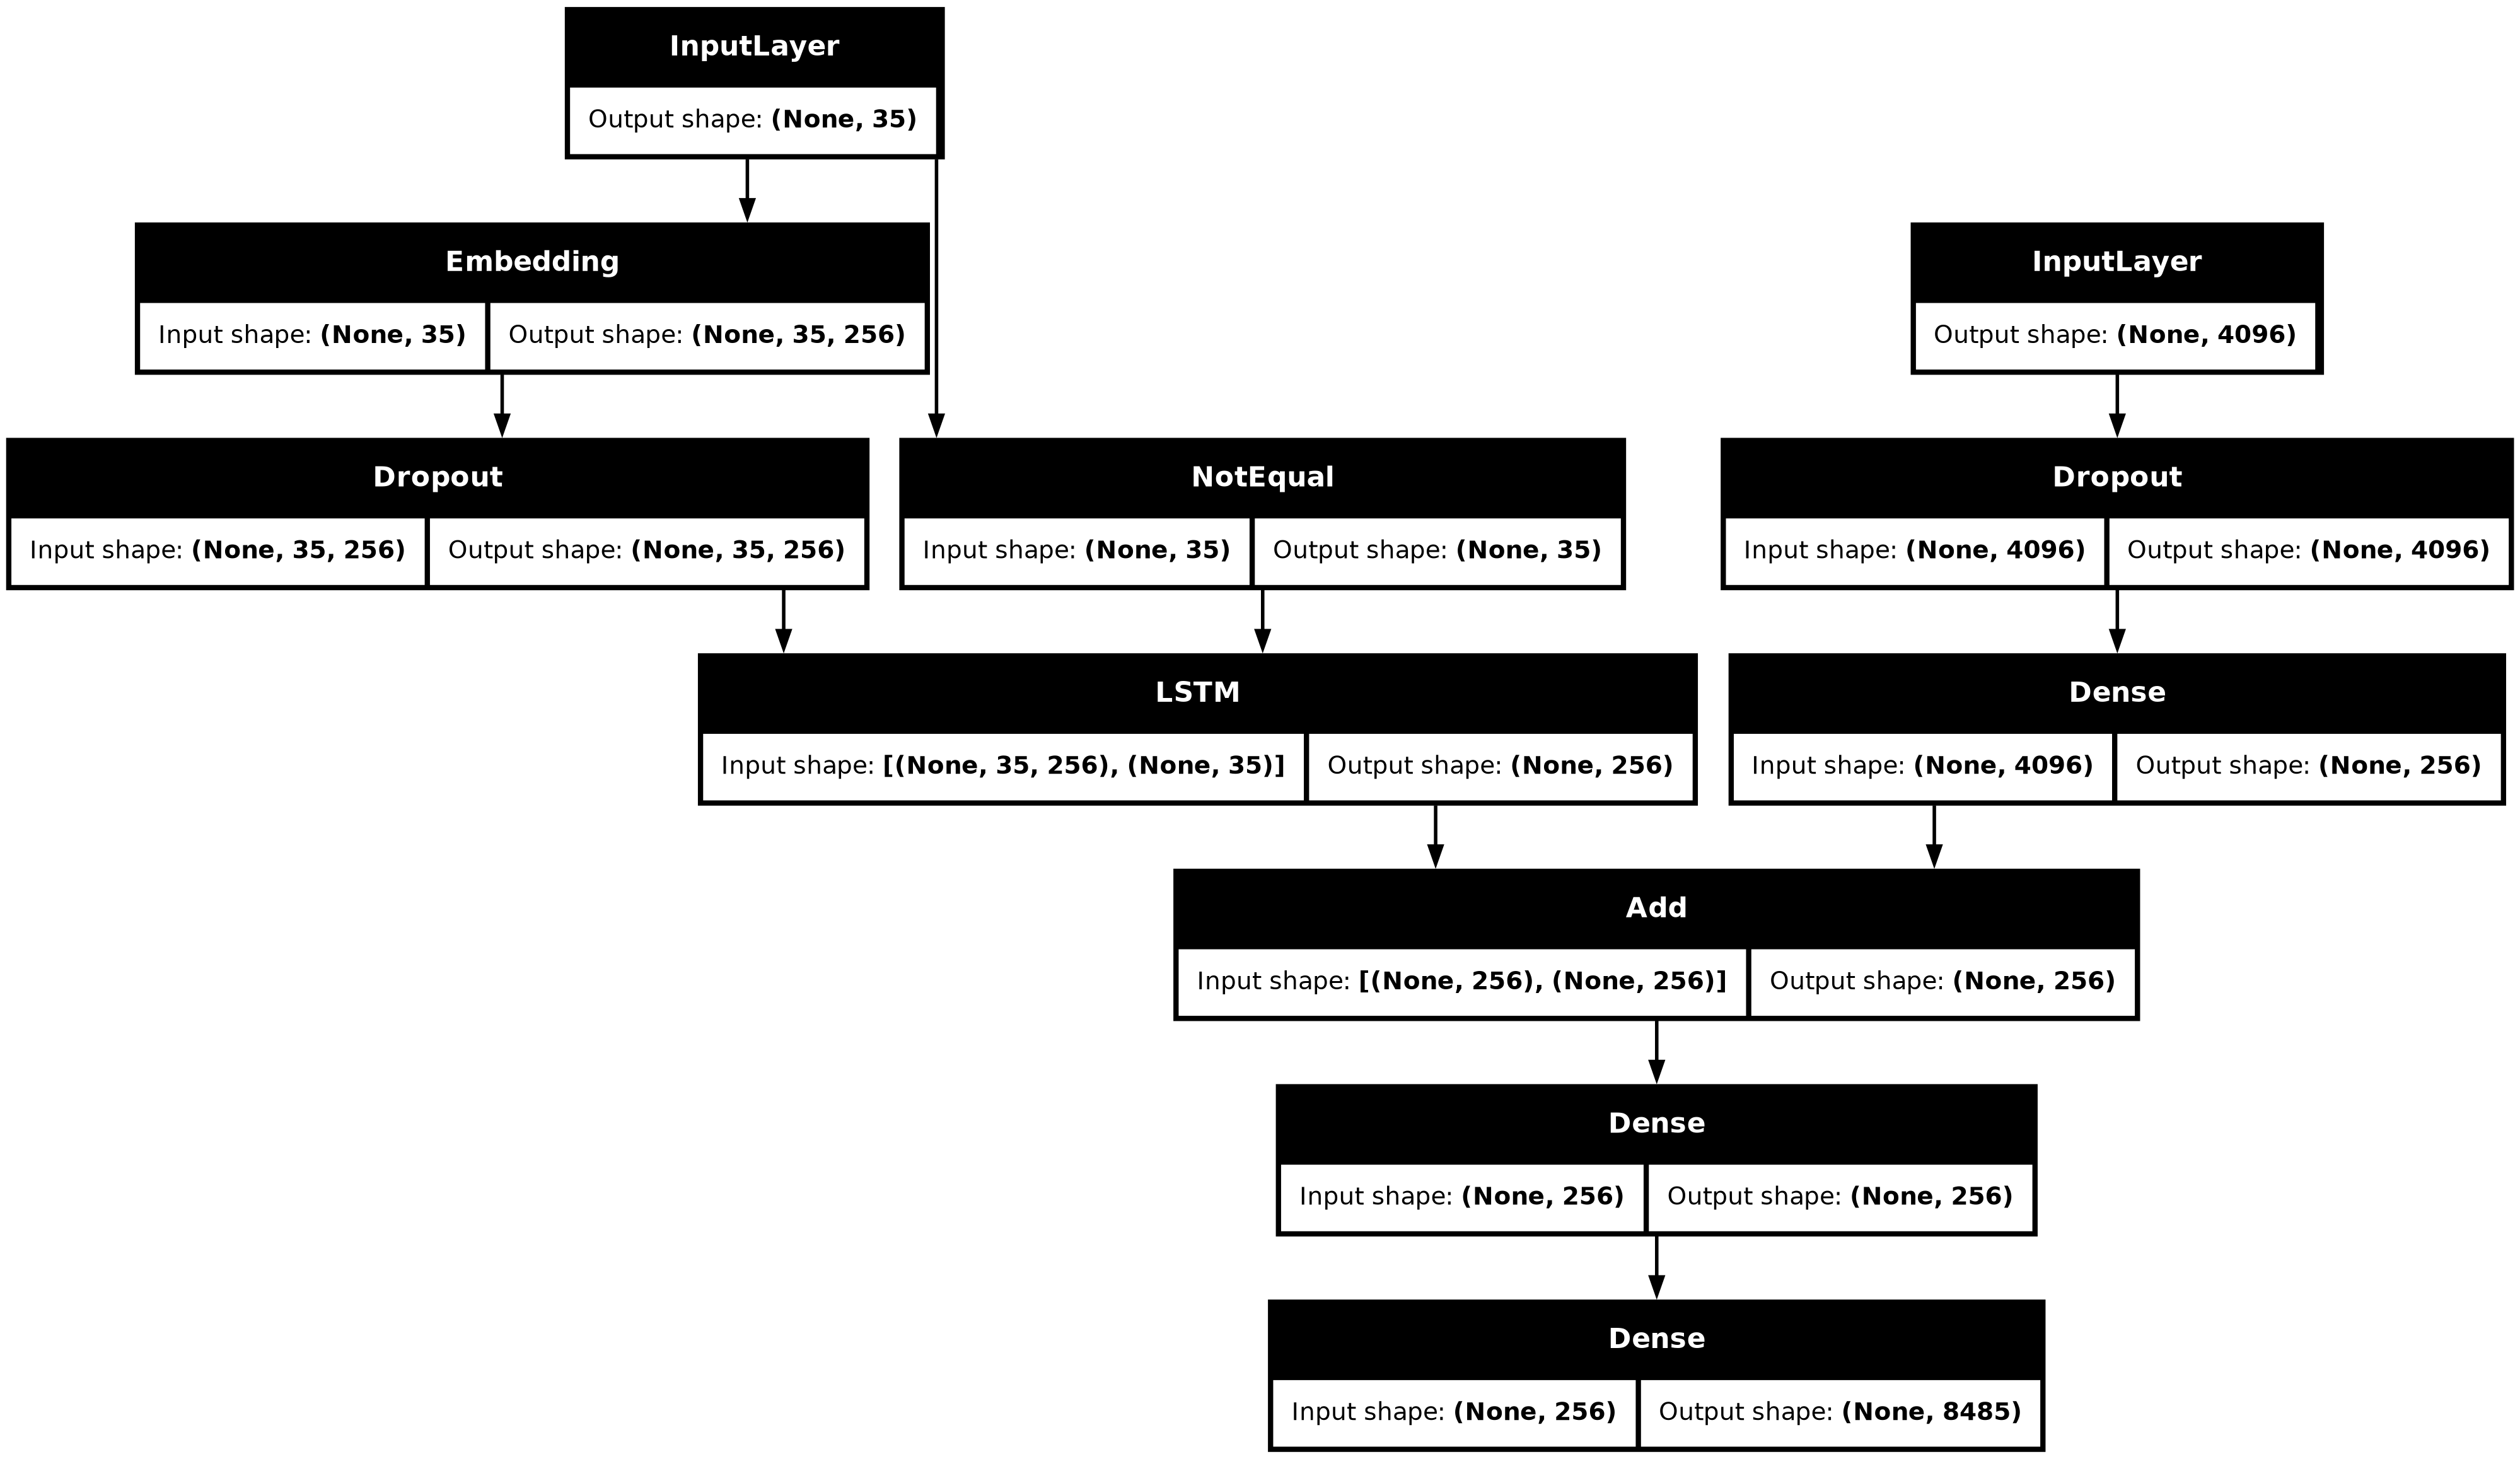

In [17]:
decoder1 = add([feat2, seq3])
decoder2 = Dense(256, activation='relu')(decoder1)
output = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[input1, input2], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer="adam")

plot_model(model, show_shapes=True)

In [18]:
epochs = 15
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 427s 4s/step - loss: 6.1277
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 507ms/step - loss: 4.4904
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 508ms/step - loss: 3.8002
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 505ms/step - loss: 3.4807
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 508ms/step - loss: 3.2670
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 506ms/step - loss: 3.1061
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 506ms/step - loss: 2.9740
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 509ms/step - loss: 2.8643
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 500ms/step - loss: 2.7803
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 501ms/step - loss: 2.7064
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 505ms/step - loss: 2.6353
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 503ms/step - loss: 2.5751
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 505ms/step - loss: 2.5280
113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 513ms/step - loss: 2.4803
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 503ms/step - loss: 2.4294


In [19]:
model.save(WORKING_DIR+'/best_model.h5')

## Generate Captions

In [20]:
def index_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

## Visualize Results

In [21]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'tagstart'
    
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        
        y_hat = model.predict([image, sequence], verbose=0)
        y_hat = np.argmax(y_hat)
        
        word = index_to_word(y_hat, tokenizer)
        
        if word is None:
            break
            
        in_text += " " + word
        
        if word == 'endtag':
            break
    return in_text

## Visualize Example

-------------------Actual-------------------
tagstart child in pink dress is climbing up set of stairs in an entry way endtag
tagstart girl going into wooden building endtag
tagstart little girl climbing into wooden playhouse endtag
tagstart little girl climbing the stairs to her playhouse endtag
tagstart little girl in pink dress going into wooden cabin endtag
-------------------Predicted-------------------
tagstart little girl in purple shirt is standing in front of wooden cabin endtag


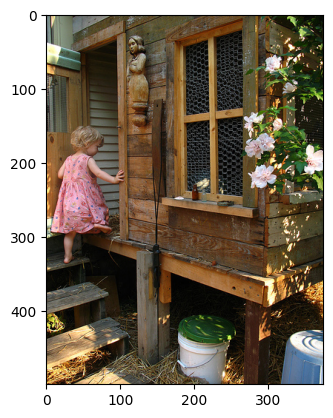

In [22]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(img_name):
    img_id = img_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", img_name)
    image = Image.open(img_path)

    captions = mapping[img_id]

    print("-------------------Actual-------------------")
    for caption in captions:
        print(caption)

    y_pred = predict_caption(model, features[img_id], tokenizer, max_length)
    print("-------------------Predicted-------------------")
    print(y_pred)
    plt.imshow(image)
    
    ###
    
generate_caption("1000268201_693b08cb0e.jpg")

## Metric Evaluation

In [23]:
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    actual.append(actual_captions)
    predicted.append(y_pred.split())

  0%|          | 0/810 [00:00<?, ?it/s]

In [24]:
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0,0,0,0))) ###
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5,0.5,0,0)))

BLEU-1: 0.556230
BLEU-2: 0.334852
